# --------------------------  CVA Avec intensité stochastique  ------------------------

In [1]:
import random 
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.special as sp

# I- Prix Call B&S par Monte Carlo

In [2]:
def PrixCall(Option,t):
    S0,K,T,r,sigma=Option[0],Option[1],Option[2],Option[3],Option[4]
    N=int(1e4)
    W=np.random.standard_normal(N)
    ST=S0*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*W)
    Mt=np.maximum(0,ST-K)
    MonteCarloprice=np.sum(Mt)*np.exp(-r*(T-t))/N
    return MonteCarloprice

L'exécution de cette fonction qui calcul le prix du call avec B&S est autant rapide que la formule fermée

# II- Expression de la CVA_WWR et  de la CVA_IND

Sous l'hypothèse de non collateral agreement, on a:


$$CVA_{WWR}=(1-R)\mathbb{E^Q}[B(0,\tau)(MtM_{\tau})^{+}\mathbb{1}_{\{\tau\leqslant T\}}] $$   

avec T l'horizon du portefeuille.\\
Lorsque la valeur de marché MtM du portefeuille est corrélée à l'instant de défaut $\tau$ on a:
$$CVA_{WWR}=(1-R)\mathbb{E^Q}[\int_{0}^{T}B(0,u)(MtM_{\tau})^{+}\mathbb{1}_{{\tau} \in [u, u+du]}]$$
$$CVA_{WWR}=(1-R)\int_{0}^{T}B(0,u)\mathbb{E^Q}[(MtM_{u})^{+}|\tau=u]\mathbb{E^Q}[\mathbb{1}_{\tau} \in [u, u+du]]$$
$$CVA_{WWR}=(1-R)\int_{0}^{T}B(0,u)\mathbb{E^Q}[(MtM_{u})^{+}|\tau=u] dP(\tau\leqslant u)$$




$$CVA_{WWR}=(1-R)\int_{0}^{T}B(0,u)\mathbb{E^Q}[(MtM_{u})^{+}|\tau=u]f_{\tau}(u)du$$   


Avec cette approche, dès qu'on suppose qu'il y a indépendance entre $\tau$ et le MtM, alors on a:


 $$CVA_{IND}=(1-R)\int_{0}^{T}B(0,u)\mathbb{E^Q}[(MtM_{u})^{+}]f_{\tau}(u)du $$ 

# III- Implémentation de la CVA_WWR

$$CVA_{WWR}=(1-R)\mathbb{E^Q}[B(0,\tau)(MtM_{\tau})^{+}\mathbb{1}_{\{\tau\leqslant T\}}] $$   

In [3]:
def CVA_corr(cor,sigmaL):
    T,sigmaS,K,r=1.0,0.2,100,0.05
    S0,Lamda0=100,1
    N=10000  # Tragectoire de MC
    M= 500  # Subdivision de l'intervalle de temps
    
    CVA=0
    Uniforme=np.random.uniform(0,1,N)
    for i in range(N):
        t,Int=0,0
        # Détermination de l'instant de défaut 
        while t<=T:
            t+=T/M
            #Calcul de St et Lambdat qui sont corrélés 
            V,W=np.random.multivariate_normal([0,0],[[1,cor],[cor,1]],1).T # 2 normales corrélées
            St=S0*np.exp((-0.5*sigmaS**2)*t+sigmaS*np.sqrt(t)*W)
            Lamdat=Lamda0*np.exp((-0.5*sigmaL**2)*t+sigmaL*np.sqrt(t)*V)
            Int+=Lamdat*T/M  #Intégrale de l'intensité
            # Détermination de l'instant de défaut
            if Uniforme[i]<=1-np.exp(-Int):
                Tho=t
                Xt=np.exp(-r*t)*np.maximum(0,St-K)
                break
        if t>T: # Le cas où il n'y a pas défaut
            Xt=0
        CVA+=Xt/N # CVA est un espérance du payoff à l'instant de défaut
    return CVA

Pour chaque trajectoire de Monte Carlo, on génère lamda et St qui sont corrélés on détermine, ensuite, l'instant de défaut qui a une intensité stochastique. A la fin, on retourne l'espérance du MtM du call calculé à l'instant de défaut.

# IV- Implémentation de la CVA_IND

 $$CVA_{IND}=(1-R)\int_{0}^{T}B(0,u)\mathbb{E^Q}[(MtM_{u})^{+}]f_{\tau}(u)du $$ 

In [4]:
def CVA_ind(sigmaL):
    T,sigmaS,K,r=1.0,0.2,100,0.05
    S0,Lamda0=100,1
    N=10000  # Tragectoire de MC
    M= 1000  # Subdivision de l'intervalle de temps
    
    Lamda=[[]]*N
    Int=[[]]*N  #Intégrale de l'intensité
    
    U=np.random.standard_normal(N)  # N trajectoire de MC
    for i in range(N):
        x=Lamda0*np.exp((-0.5*sigmaL**2)*T/M+sigmaL*np.sqrt(T/M)*U[i])
        Lamda[i].append(x)
        Int[i].append(x*T/M)
        for j in range(1,M):
            v=Lamda0*np.exp((-0.5*sigmaL**2)*(j+1)*T/M+sigmaL*np.sqrt((j+1)*T/M)*U[i])
            Lamda[i].append(v)
            Int[i].append(Int[i][j-1]+v*T/M)
    CVA=0
    for j in range(M):
        #Fonction densité de l'instant de défaut à tj
        densite=sum([Lamda[i][j]*np.exp(-Int[i][j]) for i in range(N)])/N
        #CVA en Riemann
        CVA+=PrixCall([S0,K,(j+1)*T/M,r,sigmaS],0)*densite*T/M
    return CVA

Ici, on diffuse le processus Lamda, qui représente l'intensité de l'instant de défaut, pour calculer l'espérance de la densité de l'intensité. Cette dernière est multipliée par le MtM du call calculé à l'instant ti (discritisation de l'intervalle [0,T]).

# V- CVA_WWR(cor=0)=CVA_IND

In [30]:
sigmaL=0.2
start=time.time()
x=CVA_corr(0,sigmaL)
end=time.time()
print('CVA_WWR avec corrélation nulle est: ', x, "temps d'execution ", end-start)

start=time.time()
y=CVA_ind(sigmaL)
end=time.time()
print('CVA_IND est: ', y, "temps d'execution ", end-start,'\n','le ratio: ',x/y )


CVA_WWR avec corrélation nulle est:  [2.79647105] temps d'execution  583.9299068450928
CVA_IND est:  3.471719056772695 temps d'execution  67.15697073936462 
 le ratio:  [0.80550039]


On s'attend à ce que le ratio soit proche de 1

# VI- CVA_WWR en fonction de la corrélation

In [ ]:
# Compiler CVA_WWR pour 100 valeurs de la corrélation entre [-1,1] 
X=[-1+i/50 for i in range(86)]
Y=[]
sigmaL=0.2
for x in X:
    start=time.time()
    y=CVA_corr(x,sigmaL) 
    Y.append(y)
    end=time.time()
    print('CVA_WWR pour corrélation= ', x,'est: ', y, ' temps execution: ', end-start, 'la liste de toute les valeurs: ',Y)

CVA_WWR pour corrélation=  -0.86 est:  [2.37276358]  temps execution:  441.18945360183716 la liste de toute les valeurs:  [array([2.37276358])]
CVA_WWR pour corrélation=  -0.84 est:  [2.37530701]  temps execution:  453.2218863964081 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701])]
CVA_WWR pour corrélation=  -0.8200000000000001 est:  [2.50007116]  temps execution:  470.5933105945587 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701]), array([2.50007116])]
CVA_WWR pour corrélation=  -0.8 est:  [2.48568162]  temps execution:  479.65970158576965 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701]), array([2.50007116]), array([2.48568162])]
CVA_WWR pour corrélation=  -0.78 est:  [2.48310219]  temps execution:  471.49210238456726 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701]), array([2.50007116]), array([2.48568162]), array([2.48310219])]
CVA_WWR pour corrélation=  -0.76 est:  [2.51482266]  temps 

CVA_WWR pour corrélation=  -0.4 est:  [2.656342]  temps execution:  460.6147723197937 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701]), array([2.50007116]), array([2.48568162]), array([2.48310219]), array([2.51482266]), array([2.58133529]), array([2.532152]), array([2.63999105]), array([2.58435864]), array([2.60459301]), array([2.57299991]), array([2.68585887]), array([2.54310662]), array([2.50748495]), array([2.62221524]), array([2.63032822]), array([2.63563921]), array([2.58464236]), array([2.66711006]), array([2.72365606]), array([2.63958518]), array([2.69036155]), array([2.656342])]
CVA_WWR pour corrélation=  -0.38 est:  [2.69938438]  temps execution:  467.27754855155945 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701]), array([2.50007116]), array([2.48568162]), array([2.48310219]), array([2.51482266]), array([2.58133529]), array([2.532152]), array([2.63999105]), array([2.58435864]), array([2.60459301]), array([2.57299991]), array([2

CVA_WWR pour corrélation=  -0.16000000000000003 est:  [2.8671712]  temps execution:  461.32008600234985 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701]), array([2.50007116]), array([2.48568162]), array([2.48310219]), array([2.51482266]), array([2.58133529]), array([2.532152]), array([2.63999105]), array([2.58435864]), array([2.60459301]), array([2.57299991]), array([2.68585887]), array([2.54310662]), array([2.50748495]), array([2.62221524]), array([2.63032822]), array([2.63563921]), array([2.58464236]), array([2.66711006]), array([2.72365606]), array([2.63958518]), array([2.69036155]), array([2.656342]), array([2.69938438]), array([2.75314403]), array([2.83039836]), array([2.74308965]), array([2.78793585]), array([2.74015087]), array([2.69060986]), array([2.88681434]), array([2.87878003]), array([2.77416844]), array([2.8232541]), array([2.8671712])]
CVA_WWR pour corrélation=  -0.14 est:  [2.85625421]  temps execution:  459.58160519599915 la liste de toute les v

CVA_WWR pour corrélation=  0.020000000000000018 est:  [2.99591127]  temps execution:  460.95800733566284 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701]), array([2.50007116]), array([2.48568162]), array([2.48310219]), array([2.51482266]), array([2.58133529]), array([2.532152]), array([2.63999105]), array([2.58435864]), array([2.60459301]), array([2.57299991]), array([2.68585887]), array([2.54310662]), array([2.50748495]), array([2.62221524]), array([2.63032822]), array([2.63563921]), array([2.58464236]), array([2.66711006]), array([2.72365606]), array([2.63958518]), array([2.69036155]), array([2.656342]), array([2.69938438]), array([2.75314403]), array([2.83039836]), array([2.74308965]), array([2.78793585]), array([2.74015087]), array([2.69060986]), array([2.88681434]), array([2.87878003]), array([2.77416844]), array([2.8232541]), array([2.8671712]), array([2.85625421]), array([2.91943544]), array([2.7665311]), array([2.91598672]), array([2.86223687]), array([2

CVA_WWR pour corrélation=  0.17999999999999994 est:  [3.06693603]  temps execution:  459.93773317337036 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701]), array([2.50007116]), array([2.48568162]), array([2.48310219]), array([2.51482266]), array([2.58133529]), array([2.532152]), array([2.63999105]), array([2.58435864]), array([2.60459301]), array([2.57299991]), array([2.68585887]), array([2.54310662]), array([2.50748495]), array([2.62221524]), array([2.63032822]), array([2.63563921]), array([2.58464236]), array([2.66711006]), array([2.72365606]), array([2.63958518]), array([2.69036155]), array([2.656342]), array([2.69938438]), array([2.75314403]), array([2.83039836]), array([2.74308965]), array([2.78793585]), array([2.74015087]), array([2.69060986]), array([2.88681434]), array([2.87878003]), array([2.77416844]), array([2.8232541]), array([2.8671712]), array([2.85625421]), array([2.91943544]), array([2.7665311]), array([2.91598672]), array([2.86223687]), array([2.

CVA_WWR pour corrélation=  0.32000000000000006 est:  [3.05338357]  temps execution:  463.37848711013794 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701]), array([2.50007116]), array([2.48568162]), array([2.48310219]), array([2.51482266]), array([2.58133529]), array([2.532152]), array([2.63999105]), array([2.58435864]), array([2.60459301]), array([2.57299991]), array([2.68585887]), array([2.54310662]), array([2.50748495]), array([2.62221524]), array([2.63032822]), array([2.63563921]), array([2.58464236]), array([2.66711006]), array([2.72365606]), array([2.63958518]), array([2.69036155]), array([2.656342]), array([2.69938438]), array([2.75314403]), array([2.83039836]), array([2.74308965]), array([2.78793585]), array([2.74015087]), array([2.69060986]), array([2.88681434]), array([2.87878003]), array([2.77416844]), array([2.8232541]), array([2.8671712]), array([2.85625421]), array([2.91943544]), array([2.7665311]), array([2.91598672]), array([2.86223687]), array([2.

CVA_WWR pour corrélation=  0.43999999999999995 est:  [3.27040176]  temps execution:  475.2011573314667 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701]), array([2.50007116]), array([2.48568162]), array([2.48310219]), array([2.51482266]), array([2.58133529]), array([2.532152]), array([2.63999105]), array([2.58435864]), array([2.60459301]), array([2.57299991]), array([2.68585887]), array([2.54310662]), array([2.50748495]), array([2.62221524]), array([2.63032822]), array([2.63563921]), array([2.58464236]), array([2.66711006]), array([2.72365606]), array([2.63958518]), array([2.69036155]), array([2.656342]), array([2.69938438]), array([2.75314403]), array([2.83039836]), array([2.74308965]), array([2.78793585]), array([2.74015087]), array([2.69060986]), array([2.88681434]), array([2.87878003]), array([2.77416844]), array([2.8232541]), array([2.8671712]), array([2.85625421]), array([2.91943544]), array([2.7665311]), array([2.91598672]), array([2.86223687]), array([2.8

CVA_WWR pour corrélation=  0.56 est:  [3.24253276]  temps execution:  481.1809358596802 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701]), array([2.50007116]), array([2.48568162]), array([2.48310219]), array([2.51482266]), array([2.58133529]), array([2.532152]), array([2.63999105]), array([2.58435864]), array([2.60459301]), array([2.57299991]), array([2.68585887]), array([2.54310662]), array([2.50748495]), array([2.62221524]), array([2.63032822]), array([2.63563921]), array([2.58464236]), array([2.66711006]), array([2.72365606]), array([2.63958518]), array([2.69036155]), array([2.656342]), array([2.69938438]), array([2.75314403]), array([2.83039836]), array([2.74308965]), array([2.78793585]), array([2.74015087]), array([2.69060986]), array([2.88681434]), array([2.87878003]), array([2.77416844]), array([2.8232541]), array([2.8671712]), array([2.85625421]), array([2.91943544]), array([2.7665311]), array([2.91598672]), array([2.86223687]), array([2.81342614]), arra

CVA_WWR pour corrélation=  0.6599999999999999 est:  [3.21423556]  temps execution:  1024.3048832416534 la liste de toute les valeurs:  [array([2.37276358]), array([2.37530701]), array([2.50007116]), array([2.48568162]), array([2.48310219]), array([2.51482266]), array([2.58133529]), array([2.532152]), array([2.63999105]), array([2.58435864]), array([2.60459301]), array([2.57299991]), array([2.68585887]), array([2.54310662]), array([2.50748495]), array([2.62221524]), array([2.63032822]), array([2.63563921]), array([2.58464236]), array([2.66711006]), array([2.72365606]), array([2.63958518]), array([2.69036155]), array([2.656342]), array([2.69938438]), array([2.75314403]), array([2.83039836]), array([2.74308965]), array([2.78793585]), array([2.74015087]), array([2.69060986]), array([2.88681434]), array([2.87878003]), array([2.77416844]), array([2.8232541]), array([2.8671712]), array([2.85625421]), array([2.91943544]), array([2.7665311]), array([2.91598672]), array([2.86223687]), array([2.8

In [9]:
# la suite
X=[-1+i/50 for i in range(86,101)]
Z=[]
sigmaL=0.2
for x in X:
    start=time.time()
    z=CVA_corr(x,sigmaL) 
    Z.append(z)
    end=time.time()
    print('CVA_WWR pour corrélation= ', x,'est: ', z, ' temps execution: ', end-start, 'la liste de toute les valeurs: ',Z)

CVA_WWR pour corrélation=  0.72 est:  [3.31540875]  temps execution:  1084.7500591278076 la liste de toute les valeurs:  [array([3.31540875])]
CVA_WWR pour corrélation=  0.74 est:  [3.39872733]  temps execution:  4246.776944160461 la liste de toute les valeurs:  [array([3.31540875]), array([3.39872733])]
CVA_WWR pour corrélation=  0.76 est:  [3.43584885]  temps execution:  1157.0103406906128 la liste de toute les valeurs:  [array([3.31540875]), array([3.39872733]), array([3.43584885])]
CVA_WWR pour corrélation=  0.78 est:  [3.33553688]  temps execution:  1224.9921517372131 la liste de toute les valeurs:  [array([3.31540875]), array([3.39872733]), array([3.43584885]), array([3.33553688])]
CVA_WWR pour corrélation=  0.8 est:  [3.3957709]  temps execution:  1102.54101729393 la liste de toute les valeurs:  [array([3.31540875]), array([3.39872733]), array([3.43584885]), array([3.33553688]), array([3.3957709])]
CVA_WWR pour corrélation=  0.8200000000000001 est:  [3.4779596]  temps execution:

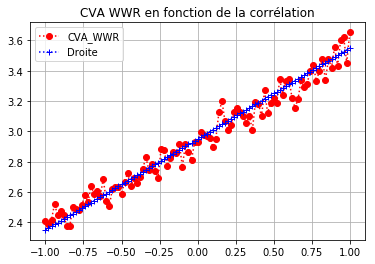

In [31]:
# L: l'ensemble des valeurs de la CVA_WWR 
L=[2.40977007,2.38622664,2.41624335,2.52255419,2.44532504,2.47740214,2.44854586,2.37276358,2.37530701,2.50007116,2.48568162,2.48310219,2.51482266,2.58133529,2.532152,2.63999105,2.58435864,2.60459301,2.57299991,2.68585887,2.54310662,2.50748495,2.62221524,2.63032822,2.63563921,2.58464236,2.66711006,2.72365606,2.63958518,2.69036155,2.656342,2.69938438,2.75314403,2.83039836,2.74308965,2.78793585,2.74015087,2.69060986,2.88681434,2.87878003,2.77416844,2.8232541,2.8671712,2.85625421,2.91943544,2.7665311,2.91598672,2.86223687,2.81342614,2.92669622,2.9292126,2.99591127,2.97503692,2.96947779,2.95861268,2.89924262,2.95275463,3.12604774,3.19890218,3.06693603,3.01192312,3.04379951,3.12563136,3.15400467,3.12761796,3.10254464,3.05338357,3.1022354,3.00847163,3.19589253,3.18166781,3.10053176,3.27040176,3.12254895,3.18944151,3.21836082,3.18469577,3.34286719,3.24253276,3.33402793,3.34787223,3.22344258,3.15533233,3.21423556,3.33679289,3.29322018,3.3154087543281943,3.3987273278268293,3.43584885461311,3.3355368842745037,3.395770895273549,3.477959602199717,3.3398063831608846,3.477258979762494,3.4208507814418967,3.5542786510821247,3.4334914222624806,3.601287006087459,3.6196771751129586,3.4531128188273987,3.65404255]
X=[-1+i/50 for i in range(101)]
Droite=[0.6*X[i]+2.95 for i in range(101)] # La droite qui approxime l'évolution de CVA_WWR en fonction de la corr
plt.plot(X,L,'r:o',label='CVA_WWR')
plt.plot(X,Droite,'b:+',label='Droite')
plt.grid()
plt.legend()
plt.title('CVA WWR en fonction de la corrélation')
plt.show()

Dans ce modèle, on a pris un call de paramètres suivants: S0=100, T=1.0,sigmaS=0.2, K=100, r=0.05.

Par ailleurs, on a pris comme modèle d'intensité stochastique le brownien géométrique avec sigmaL=0.2 et Lamda0=100.

On remarque que la CVA_WWR croît d'une façon presque constante en fonction de la corrélation.

# VII- Evolution du ratio CVA_WWR/CVA_IND avec la volatilité de l'intensité

In [5]:
cor=0.5
Sigma=[i/20 for i in range(11)]
for sigmaL in Sigma:
    start=time.time()
    x=CVA_corr(cor,sigmaL)/CVA_ind(sigmaL)
    end=time.time()
    print('Ratio pour sigma= ', sigmaL,'est: ', x, ' temps execution: ', end-start)

Ratio pour sigma=  0.0 est:  [0.81078932]  temps execution:  616.7668323516846
Ratio pour sigma=  0.05 est:  [0.80523235]  temps execution:  586.5817167758942
Ratio pour sigma=  0.1 est:  [0.84004011]  temps execution:  645.194812297821
Ratio pour sigma=  0.15 est:  [0.87618716]  temps execution:  570.8925449848175
Ratio pour sigma=  0.2 est:  [0.92553802]  temps execution:  585.4873774051666
Ratio pour sigma=  0.25 est:  [0.97294573]  temps execution:  579.3844530582428
Ratio pour sigma=  0.3 est:  [0.92977482]  temps execution:  595.2602546215057
Ratio pour sigma=  0.35 est:  [0.82554539]  temps execution:  589.8615477085114
Ratio pour sigma=  0.4 est:  [1.22751652]  temps execution:  605.7645497322083
Ratio pour sigma=  0.45 est:  [1.23149062]  temps execution:  609.1170387268066
Ratio pour sigma=  0.5 est:  [1.12040366]  temps execution:  651.9317123889923


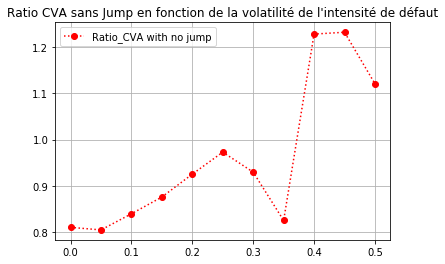

In [36]:
Ratio_CVA=[0.81078932,0.80523235,0.84004011,0.87618716,0.92553802,0.97294573,0.92977482,0.82554539,1.22751652,1.23149062,1.12040366]
Sigma=[i/20 for i in range(11)]
plt.plot(Sigma,Ratio_CVA,"r:o",label='Ratio_CVA with no jump')
plt.legend()
plt.grid()
plt.title("Ratio CVA sans Jump en fonction de la volatilité de l'intensité de défaut")
plt.show()

En remarque que le ratio continue de croître jusqu'à atteindre une valeur maximale en σX = 0.25. Ensuite, il décroît puis décole en σX = 0.35.